## Digit Classification with the MNIST Dataset
A hand-drawn set of digits with labels is used to train and then classify a test set of "new" digits with a common machine learning classification algorithm and using chunked data for out-of-core storage and computation.  Python `dask` and `scikit-learn` libraries are used here.

In [1]:
%matplotlib inline

from matplotlib.pyplot import imshow, plot, subplot, figure
from scipy.ndimage import uniform_filter
from scipy.misc import imread
import dask.array as da
import numpy as np

/home/nbuser/anaconda3_410/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/nbuser/anaconda3_410/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Get the MNIST dataset
A little on the MNIST digit data set (exerpt from [here](http://deeplearning.net/tutorial/gettingstarted.html)).

The MNIST dataset consists of handwritten digit images and it is divided in 60,000 examples for the training set and 10,000 examples for testing. In many papers as well as in this tutorial, the official training set of 60,000 is divided into an actual training set of 50,000 examples and 10,000 validation examples (for selecting hyper-parameters like learning rate and size of the model). All digit images have been size-normalized and centered in a fixed size image of 28 x 28 pixels. In the original dataset each pixel of the image is represented by a value between 0 and 255, where 0 is black, 255 is white and anything in between is a different shade of grey.

Here are some examples of MNIST digits:

![digits](http://deeplearning.net/tutorial/_images/mnist_1.png)![digits](http://deeplearning.net/tutorial/_images/mnist_2.png)![digits](http://deeplearning.net/tutorial/_images/mnist_3.png)![digits](http://deeplearning.net/tutorial/_images/mnist_4.png)![digits](http://deeplearning.net/tutorial/_images/mnist_5.png)

For convenience we pickled the dataset to make it easier to use in python. It is available for download here. The pickled file represents a tuple of 3 lists : the training set, the validation set and the testing set. Each of the three lists is a pair formed from a list of images and a list of class labels for each of the images. An image is represented as numpy 1-dimensional array of 784 (28 x 28) float values between 0 and 1 (0 stands for black, 1 for white). The labels are numbers between 0 and 9 indicating which digit the image represents. The code block below shows how to load the dataset.

Download:

In [15]:
!if [ ! -e mnist.pkl.gz ]; then wget -q https://github.com/michhar/python-jupyter-notebooks/raw/master/bigdata/images/mnist.pkl.gz; fi

In [16]:
!ls -lh

total 47M
lrwxrwxrwx 1 nbuser nbuser  28 Sep 24 09:25 anaconda2_410 -> /home/nbcommon/anaconda2_410
lrwxrwxrwx 1 nbuser nbuser  28 Sep 24 09:25 anaconda3_410 -> /home/nbcommon/anaconda3_410
-rw-r--r-- 1 nbuser nbuser 16M Sep 24 17:13 mnist.pkl.gz
-rw-r--r-- 1 nbuser nbuser 32M Sep 24 17:08 stitched--U00--V00--C00--Z00.png


Use pickle to load the MNIST archive file into the training, validation and test sets

In [17]:
import pickle, gzip
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='bytes')

### Check the dataset

Let's check the first image by viewing the digit and checking the label - feel free to check others

784 pixels, shape (28, 28), dtype uint8 (50000 total digit images)
Label: 5


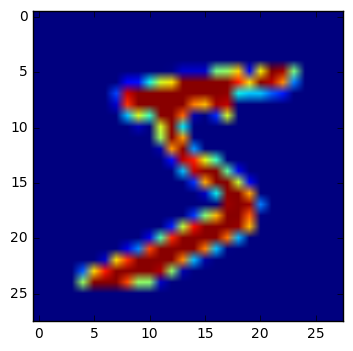

In [44]:
digit_idx = 0 # change to check other digits

img = train_set[0][digit_idx].reshape(28, 28)
img = (img*255).astype(np.uint8) # image read as float32, image is 8 bit grayscale
imshow(img)

num_pix = str(img.shape[0] * img.shape[1])
print('%s pixels, shape %s, dtype %s (%d total digit images)' % (num_pix, img.shape, img.dtype, len(train_set[0])))
print('Label: %d' % train_set[1][digit_idx])

### Place the data into dask arrays for out-of-core computations
Here we also chunk the data

In [50]:
X_train = da.from_array(train_set[0], chunks=(1000, 1000))
y_train = da.from_array(train_set[1], chunks=(1000, 1000))

X_test = da.from_array(test_set[0], chunks=(1000))
y_test = da.from_array(test_set[1], chunks=(1000))

### Define and fit our learner for classification - Stochastic Gradient Descent classifier
A little on SGD from [this](http://deeplearning.net/tutorial/gettingstarted.html) deep learning tutorial.  SGD from Python's `scikit-learn` ML library can be utilized here on chunks of data on disk because it supports batch learning (or online learning) using partial fitting.

What is ordinary gradient descent? it is a simple algorithm in which we repeatedly make small steps downward on an error surface defined by a loss function of some parameters. For the purpose of ordinary gradient descent we consider that the training data is rolled into the loss function.

Stochastic gradient descent (SGD) works according to the same principles as ordinary gradient descent, but proceeds more quickly by estimating the gradient from just a few examples at a time instead of the entire training set. In its purest form, we estimate the gradient from just a single example at a time.

In [54]:
from sklearn.linear_model import SGDClassifier

# Instatiate
sgd = SGDClassifier()

# Fit
%time sgd = da.learn.fit(sgd, X_train, y_train, classes=range(0, 10))

CPU times: user 944 ms, sys: 32 ms, total: 976 ms
Wall time: 970 ms


### Predict classes of digits

In [47]:
# Dask.learn predict method
y_pred = da.learn.predict(sgd, X_test)

In [39]:
# Convert back to an array by slicing and check first 10 predictions
y_pred[:10].compute()

array([7, 2, 1, 0, 4, 1, 4, 9, 6, 9])

In [45]:
# Check the actual labels - do they agree?
y_test[:10].compute()

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])